In [ ]:

!pip install segmentation-models-pytorch
!pip install pytorch-msssim
!pip install ptflops
!pip install lpips
!pip install --upgrade pip
!pip install torch
!pip install cv2
!pip install scikit-image
!pip install albumentations
!pip install einops
!pip install wandb
!pip install torchmetrics
!pip install pyiqa

#!apt-get update && apt-get install libgl1 -y
#!apt-get update && apt-get install -y python3-opencv
#!pip install opencv-python
from torch.nn.utils import spectral_norm
from pytorch_msssim import ms_ssim, ssim, ssim as f_ssim
from ptflops import get_model_complexity_info
import segmentation_models_pytorch as smp
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image, make_grid
from torchvision.models import resnet50, densenet121, DenseNet121_Weights, ResNet50_Weights
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys
import gc
import numpy as np
import torchvision
from tqdm import tqdm
from skimage.metrics import mean_squared_error as f_mse
from skimage.metrics import peak_signal_noise_ratio as f_psnr
from skimage.metrics import structural_similarity as f_ssim
from skimage.metrics import normalized_root_mse as f_nrmse
from skimage.metrics import normalized_mutual_information as f_nmi
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import cv2
from torchvision.models import vgg19, VGG19_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
from einops import rearrange, repeat

from google.colab import drive
drive.mount('/content/drive')

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model

In [ ]:

# for other networks
def initialize_weights(net_l, scale=1):
    if not isinstance(net_l, list):
        net_l = [net_l]
    for net in net_l:
        for m in net.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale  # for residual block
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias.data, 0.0)

class CAN(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CAN, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.SiLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SAN(nn.Module):
    def __init__(self, kernel_size=7):
        super(SAN, self).__init__()
        self.conv    = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out = torch.max(x, dim=1, keepdim=True)[0]
        out = torch.concat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return x * self.sigmoid(out)

class BAM(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.channel_attn = CAN(channel)
        self.spatial_attn = SAN()

    def forward(self, x):
        attn = x + self.channel_attn(x)
        attn = x + self.spatial_attn(attn)
        return attn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.down = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        ide = self.down(x)
        out += ide
        out = self.relu(out)
        return out

class DenseBlock(nn.Module):
    def __init__(self, channels, num_blocks):
        super(DenseBlock, self).__init__()
        self.conv = ResidualBlock(channels, channels)
        self.blocks = []
        for _ in range(1, num_blocks):
            self.blocks.append(ResidualBlock(channels, channels))

        self.blocks = nn.ModuleList(self.blocks)

    def forward(self, x):
        res = self.conv(x)
        for block in self.blocks:
            res = block(res)
        return res

class UpScaleBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, scale_factor=2):
        super(UpScaleBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.ups  = nn.Upsample(scale_factor=scale_factor, mode='bicubic', align_corners=False) # nearest
        self.silu = nn.SiLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.ups(x)
        x = self.silu(x)
        return x

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        x1 = adjust(x1, x2)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(32, out_channels),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(32, out_channels),
            nn.SiLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[32, 64, 128, 256]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups   = nn.ModuleList()
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of U-Net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of U-Net
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        rx = x
        # Downsampling
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Upsampling
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            # Adjust x size to match skip connection
            if x.shape != skip_connection.shape:
                x = adjust_size(x, skip_connection)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)


        x = self.final_conv(x)
        return x + rx

def adjust(x1, x2):
    x1 = F.interpolate(x2, size=x2.shape[2:], mode='bicubic', align_corners=False)
    return x1

class Generator(nn.Module):
    def __init__(self, in_channels=3, dim=64, scale_factor=4, patch_size=16):
        super(Generator, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernel_size=1),
            nn.SiLU(inplace=True)
        )

        self.ds1 = DenseBlock(dim, 4)
        self.at1 = BAM(dim)

        # ViT-like Transformer
        self.patch_embed = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=patch_size, stride=patch_size),
            nn.SiLU(inplace=True)
        )
        # image shape is (B, C, H/p, W/p)
        self.unet1 = UNet(dim, dim)

        self.ds2 = DenseBlock(dim, 3)
        self.at2 = BAM(dim)

        # Attention mechanisms
        self.up1 = nn.Sequential(
            UpScaleBlock(dim),
            BAM(dim)
        )
        self.ds3 = DenseBlock(dim, 3)
        self.at3 = BAM(dim)

        self.up2 = nn.Sequential(
            UpScaleBlock(dim),
            BAM(dim)
        )
        self.ds4 = DenseBlock(dim, 3)
        self.at4 = BAM(dim)

        self.unet2 = UNet(dim, dim)

        # Final layers
        self.conv2 = nn.Sequential(
            nn.GroupNorm(32, dim),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(dim, in_channels, kernel_size=1, padding=0),
            nn.Sigmoid()
        )
        self.scale_factor = scale_factor
        initialize_weights(self, scale=0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.ds1(x)
        x = self.at1(x)
        r = x
        # ViT-like processing
        x = self.patch_embed(x)
        x = x + self.unet1(x)

        x = self.ds2(x)
        x = self.at2(x)

        # Apply attention mechanisms
        x = self.up1(x)
        x = self.ds3(x)
        x = self.at3(x)
        x = self.up2(x)
        x = self.ds4(x)
        x = self.at4(x)
        r = F.interpolate(r, scale_factor=0.25, mode='bicubic', align_corners=False)
        x = self.unet2(x)
        x = adjust(x, r)
        x = r + x

        # Final layer
        x = self.conv2(x)

        return x.float().clamp(0, 1)

torch.Size([1, 3, 64, 64])


# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.convolution_section = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            ConvolutionalBlock(64, 64, kernel_size=3, stride=2, padding=1), # 64 x 64
            ConvolutionalBlock(64, 128, kernel_size=3, stride=1, padding=1),
            ConvolutionalBlock(128, 128, kernel_size=3, stride=2, padding=1), # 32 x 32
            ConvolutionalBlock(128, 256, kernel_size=3, stride=1, padding=1),
            ConvolutionalBlock(256, 256, kernel_size=3, stride=2, padding=1), # 16 x 16
            ConvolutionalBlock(256, 512, kernel_size=3, stride=1, padding=1),
            ConvolutionalBlock(512, 512, kernel_size=3, stride=2, padding=1) # 8 x 8
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(in_features=512*8*8, out_features=1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=1024, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.convolution_section(x)
        out = self.classifier(out)

        return out

class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=0, padding=0):
        super(ConvolutionalBlock, self).__init__()
        # Must use Sequential so we dont overide batchnorms later
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2))

    def forward(self, x):
        out = self.block(x)
        return out

# Loss

In [ ]:
from torch.autograd import Variable

class VGGLoss(nn.Module):
    def __init__(self, layer=36, device='cpu'):
        super().__init__()

        self.vgg = vgg19(weights=VGG19_Weights.DEFAULT).features[:layer].eval().to(device)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        vgg_input_features = self.vgg(output)
        vgg_target_features = self.vgg(target)
        loss = self.loss(vgg_input_features, vgg_target_features)
        del vgg_input_features, vgg_target_features
        gc.collect()
        torch.cuda.empty_cache()

        return loss

class CharbonnierLoss(nn.Module):
    def __init__(self, epsilon=1e-3):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, pred, target):
        diff = pred - target
        loss = torch.mean(Variable(torch.sqrt(diff * diff + self.epsilon * self.epsilon).type(torch.FloatTensor), requires_grad=True))
        return loss

class MSEGDL(nn.Module):
    def __init__(self, lambda_mse=1, lambda_gdl=1):
        super(MSEGDL, self).__init__()
        self.lambda_mse = lambda_mse
        self.lambda_gdl = lambda_gdl

    def forward(self, inputs, targets):

        squared_error = (inputs - targets).pow(2)
        gradient_diff_i = (inputs.diff(axis=-1)-targets.diff(axis=-1)).pow(2)
        gradient_diff_j =  (inputs.diff(axis=-2)-targets.diff(axis=-2)).pow(2)
        loss = (self.lambda_mse*squared_error.sum() + self.lambda_gdl*gradient_diff_i.sum() + self.lambda_gdl*gradient_diff_j.sum())/inputs.numel()

        return loss

class SSIMLoss(nn.Module):
    def __init__(self, data_range=1.0, size_average=True):
        super(SSIMLoss, self).__init__()
        self.data_range = data_range
        self.size_average = size_average

    def forward(self, img1, img2):
        return 1 - Variable(ssim(img1, img2, data_range=self.data_range, size_average=self.size_average).type(torch.FloatTensor), requires_grad=True)

class MSSSIMLoss(nn.Module):
    def __init__(self, data_range=1.0, size_average=True):
        super(MSSSIMLoss, self).__init__()
        self.data_range = data_range
        self.size_average = size_average

    def forward(self, img1, img2):
        return 1 - Variable(ms_ssim(img1, img2, data_range=self.data_range, size_average=self.size_average).type(torch.FloatTensor), requires_grad=True)

# Combined Loss Function
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.vgg_loss = VGGLoss()
        self.gan_loss = MSEGDL()
        self.ms_loss  = SSIMLoss()
        self.l1_loss  = CharbonnierLoss()

    def forward(self, output, target):
        vgg_loss = self.vgg_loss(output, target)
        gan_loss = self.gan_loss(output, target)
        ms_loss  = self.ms_loss(output, target)
        l1_loss  = self.l1_loss(output, target)
        return 10 * l1_loss + 8 * vgg_loss + 6 * ms_loss + 3 * gan_loss

def gradient_penalty(critic, real, fake, device):
    batch_size, channels, height, width = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, channels, height, width).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

# Metrics

In [ ]:

####################
# metric
####################

import random

# Training and Validation Functions
def calculate_metrics(pred, target):
    """Calculate PSNR and SSIM metrics"""
    mse = F.mse_loss(pred, target)
    psnr = 10 * torch.log10(1 / mse)
    ssim_value = ssim(pred, target, data_range=1.0, size_average=True)
    return psnr.item(), ssim_value.item()

def get_model_size(model):
    """
    Calculates the size of a PyTorch model in megabytes (MB).

    Args:
        model (torch.nn.Module): The PyTorch model to calculate the size for.

    Returns:
        float: The size of the model in megabytes (MB).
    """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    total_size = (param_size + buffer_size) / 1024**2
    return total_size

def plot_dataset(train_loader):
    fig, axes = plt.subplots(2, 5, figsize=(14, 7))

    for i, (low_res, high_res) in enumerate(train_loader):
        if i >= 5:
            plt.show()
            break

        axes[0, i].imshow(low_res[0].permute(1, 2, 0))
        axes[0, i].set_title("Low Resolution")
        axes[0, i].axis('off')

        axes[1, i].imshow(high_res[0].permute(1, 2, 0))
        axes[1, i].set_title("High Resolution")
        axes[1, i].axis('off')

def get_pil_image(image_tensor):
    transform = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t*255.),
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])
    return transform(image_tensor)

def save_image_tensor(tensor_image, image_name):
    transform = transforms.Compose([
        transforms.Lambda(lambda t: (t+1)/2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])
    # Convert the tensor image to a PIL image
    pil_image = transform(tensor_image)
    # Save the PIL image
    pil_image.save(image_name)

def save_pil_image(image, image_name):
    image.save(image_name)


def save_samples(encoder, real_images, low_images, index, sample_dir='generated', show=True):
  with torch.no_grad():
    encoder.to('cpu')
    fake_images = encoder(real_images)
    fake_name = "generated-images-{0:0=4d}.png".format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_name), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(low_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()
    encoder.to(device)

def get_pil_images(image_tensor):
    transform = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(0, 2, 3, 1)),
        transforms.Lambda(lambda t: t*255.),
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])
    return transform(image_tensor)

def get_pil_image(image_tensor):
    transform = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t*255.),
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])
    return transform(image_tensor)

def show(image, output):
    plt.subplot(1, 2, 1)
    plt.imshow(get_pil_image(image.detach().cpu().squeeze(0)))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(get_pil_image(output.detach().cpu().squeeze(0)))
    plt.title('UpSample Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

def subshow(gen, n_samples=7):
    fig, axes = plt.subplots(2, n_samples, figsize=(18, 11))
    for i, (low_res, high_res) in enumerate(val_loader):
        if i >= 5:
            plt.show()
            break

        sr_img = gen(high_res)
        axes[0, i].imshow(high_res[0].permute(1, 2, 0))
        axes[0, i].set_title("High Resolution")
        axes[0, i].axis('off')

        axes[1, i].imshow(sr_img[0].permute(1, 2, 0))
        axes[1, i].set_title("Super High Resolution")
        axes[1, i].axis('off')
        del sr_img, low_res, high_res
        torch.cuda.empty_cache()

def save_image_tensor(tensor_image, image_name):
  # Convert the tensor image to a PIL image
  pil_image = get_pil_image(tensor_image.squeeze(0))
  # Save the PIL image
  pil_image.save(image_name)

def get_model_size(model):
    """
    Calculates the size of a PyTorch model in megabytes (MB).

    Args:
        model (torch.nn.Module): The PyTorch model to calculate the size for.

    Returns:
        float: The size of the model in megabytes (MB).
    """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    total_size = (param_size + buffer_size) / 1024**2
    return total_size

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

#Datasets

In [ ]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image, ImageFile
import torchvision.transforms as transforms
import random
import numpy as np
import os

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, split='train', patch_size=256, scale_factor=4):
        """
        Dataset for super-resolution training/validation

        Args:
            root_dir: Root directory containing high-resolution images
            split: 'train' or 'val'
            patch_size: Size of high-resolution training patches (only used during training)
            scale_factor: Downsampling factor for creating low-resolution images
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.patch_size = patch_size
        self.scale_factor = scale_factor
        self.lr_patch_size = patch_size // scale_factor

        # Get high-resolution images with multiple extensions
        self.hr_dir = self.root_dir

        # Common image extensions
        self.extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp']

        # Get all high-resolution images
        self.hr_files = []
        for ext in self.extensions:
            self.hr_files.extend(list(self.hr_dir.glob(f'*{ext}')))
            self.hr_files.extend(list(self.hr_dir.glob(f'*{ext.upper()}')))

        # Sort the files to ensure deterministic behavior
        self.hr_files = sorted(self.hr_files)

        print(f"Found {len(self.hr_files)} high-resolution images in {self.hr_dir}")

        # Basic transforms
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        # Augmentation transforms for training
        self.augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
        ]) if split == 'train' else None

    def __len__(self):
        return len(self.hr_files)

    def get_random_crop_params(self, img):
        """Get random crop parameters for high-resolution image"""
        w, h = img.size
        th, tw = self.patch_size, self.patch_size
        if w == tw and h == th:
            return 0, 0, h, w
        if w < tw or h < th:
            # Handle images smaller than patch size by resizing
            scale = max(tw / w, th / h) * 1.1  # Scale up with a small margin
            new_w, new_h = int(w * scale), int(h * scale)
            img = img.resize((new_w, new_h), Image.BICUBIC)
            w, h = new_w, new_h

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw, img

    def create_low_res(self, hr_img):
        """Create low-resolution image by downscaling with bicubic interpolation"""
        w, h = hr_img.size
        lr_w, lr_h = w // self.scale_factor, h // self.scale_factor
        lr_img = hr_img.resize((lr_w, lr_h), Image.BICUBIC)
        return lr_img

    def __getitem__(self, idx):
        try:
            # Load high-resolution image
            hr_path = self.hr_files[idx]

            # Open image with PIL
            try:
                hr_img = Image.open(hr_path).convert('RGB')
            except Exception as e:
                print(f"Error loading image: {e}")
                # Return a random sample as fallback
                return self.__getitem__(random.randint(0, len(self) - 1))

            # Random crop for training
            if self.split == 'train':
                # Handle random cropping with potential resizing
                i, j, h, w, hr_img_resized = self.get_random_crop_params(hr_img)
                if hr_img_resized is not hr_img:  # If image was resized
                    hr_img = hr_img_resized

                # Crop high-resolution image
                hr_img = hr_img.crop((j, i, j + w, i + h))

                # Apply augmentation
                if random.random() > 0.5 and self.augment:
                    hr_img = self.augment(hr_img)

            # Create low-resolution version
            lr_img = self.create_low_res(hr_img)

            # Convert to tensors
            hr_tensor = self.transform(hr_img)
            lr_tensor = self.transform(lr_img)

            return lr_tensor, hr_tensor

        except Exception as e:
            print(f"Error processing image {idx}: {e}")
            # Return a random sample as fallback
            return self.__getitem__(random.randint(0, len(self) - 1))


def create_dataloaders(root_dir_train, root_dir_val, batch_size=8, patch_size=256, scale_factor=4, num_workers=4):
    """Create training and validation dataloaders for super-resolution"""
    train_dataset = SuperResolutionDataset(root_dir_train, split='train', patch_size=patch_size, scale_factor=scale_factor)
    val_dataset = SuperResolutionDataset(root_dir_val, split='train', patch_size=patch_size, scale_factor=scale_factor)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader

# Trainer

In [ ]:
import wandb
from typing import Tuple, Dict
import lpips


class Trainer:
    def __init__(
        self,
        model: Generator,
        discriminator: Discriminator,
        train_dataloader: torch.utils.data.DataLoader,
        val_dataloader: torch.utils.data.DataLoader,
        resume=True,
        device: str = 'cuda',
        log_dir: str = 'logs',
        learning_rate: float = 1e-4,
        perceptual_weight: float = 1.0,
        adversarial_weight: float = 0.1,
        pixel_weight: float = 20.0,
        gp_weight: float = 10.0,
        discriminator_start_iter: int = 2000,
        max_epochs: int = 100,
        save_every: int = 2000,
        validate_every: int = 2000,
        project_name: str = 'EFLIC-Compressor',
        name: str = 'eflic',
        key: str = '871660b32e58460bc0976bd8fc2afa8001243f43'
    ):

        self.model = model.to(device)
        self.discriminator    = discriminator.to(device)
        self.train_dataloader = train_dataloader
        self.val_dataloader   = val_dataloader
        self.device           = device
        self.log_dir          = log_dir
        self.max_epochs = max_epochs
        self.save_every = save_every
        self.validate_every = validate_every
        self.resume = resume

        # Push everything to gpu if it's available
        self.content_criterion = CombinedLoss().to(device)
        self.criterion_pixel   = nn.L1Loss().to(device)

        # Optimizers
        self.model_optimizer  = torch.optim.Adam(self.model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
        self.disc_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

        # Weights
        self.pixel_weight = pixel_weight
        self.gp_weight    = gp_weight
        self.perceptual_weight = perceptual_weight
        self.adversarial_weight = adversarial_weight
        self.discriminator_start_iter = discriminator_start_iter

        # Initialize wandb
        wandb.login(key=key)
        wandb.init(project=project_name, name=name, dir=log_dir)

        # Gradient scaler for mixed precision
        self.g_scaler = torch.amp.GradScaler('cuda')
        self.d_scaler = torch.amp.GradScaler('cuda')

        # Scheduler
        self.gen_scheduler  = optim.lr_scheduler.OneCycleLR(self.model_optimizer, max_lr=learning_rate, steps_per_epoch=int(len(train_dataloader)), epochs=max_epochs)
        self.disc_scheduler = optim.lr_scheduler.OneCycleLR(self.disc_optimizer, max_lr=learning_rate, steps_per_epoch=int(len(train_dataloader)), epochs=max_epochs)

        # Create directories
        os.makedirs(self.log_dir, exist_ok=True)

        self.path = f"{self.log_dir}/checkpoint_local.pt"

        print("Model's Total Num Model Parameters: {}".format(sum([param.nelement() for param in self.model.parameters()])))
        model_size = get_model_size(self.model)
        print(f"The model size is {model_size:.2f} MB")

    def train_step(self, lr_imgs: torch.Tensor, hr_imgs: torch.Tensor,  global_step: int) -> Dict[str, float]:
        self.model.train()
        self.discriminator.train()

        lr_imgs = lr_imgs.to(self.device)
        hr_imgs = hr_imgs.to(self.device)

        # Gen forward pass
        with torch.amp.autocast('cuda'):
            sr_imgs = self.model(hr_imgs)
            # Generator loss
            content_loss = self.content_criterion(sr_imgs, lr_imgs)
            # Adversarial loss (if after start iteration)
            if global_step > self.discriminator_start_iter:
                adv_loss = -torch.mean(discriminator(sr_imgs))
            else:
                adv_loss = torch.tensor(0.0)

            # Total Gen loss
            gen_loss = self.perceptual_weight * content_loss + self.adversarial_weight * adv_loss

        # Update Gen
        self.model_optimizer.zero_grad()
        self.g_scaler.scale(gen_loss).backward()
        self.g_scaler.step(self.model_optimizer)
        self.g_scaler.update()
        self.gen_scheduler.step()

        # Discriminator update (if after start iteration)
        if global_step > self.discriminator_start_iter:
            with torch.amp.autocast('cuda'):
                critic_real = discriminator(lr_imgs)
                critic_fake = discriminator(sr_imgs.detach())
                loss_pixel  = self.pixel_weight * self.criterion_pixel(critic_fake, critic_real)
                gp = self.gp_weight * gradient_penalty(self.discriminator, lr_imgs, sr_imgs, device=self.device)
                loss_real = -torch.mean(critic_real)
                loss_fake = torch.mean(critic_fake)
                disc_loss = loss_real + loss_fake
                loss_critic = disc_loss + gp + loss_pixel
                del critic_real, critic_fake
                torch.cuda.empty_cache()

            # Backpropagate and update discriminator
            self.disc_optimizer.zero_grad()
            self.d_scaler.scale(loss_critic).backward()
            self.d_scaler.step(self.disc_optimizer)
            self.d_scaler.update()
            self.disc_scheduler.step()

        # Compute metrics
        with torch.no_grad():
            psnr = -10 * torch.log10(F.mse_loss(sr_imgs, lr_imgs))
            ssim_val = ssim(sr_imgs, lr_imgs, data_range=1.0)

        # Log metrics
        metrics = {
            'loss/content': content_loss.item(),
            'loss/adv': adv_loss.item(),
            'loss/compressor': gen_loss.item(),
            'metrics/psnr': psnr.item(),
            'metrics/ssim': ssim_val.item(),
        }

        if global_step > self.discriminator_start_iter:
            metrics.update({
                'loss/discriminator': disc_loss.item(),
                'loss/d_real': loss_real.item(),
                'loss/d_fake': loss_fake.item(),
                'loss/gp': gp.item(),
                'loss/dpl': loss_pixel.item()
            })
        else:
            metrics.update({
                'loss/discriminator': torch.tensor(0.0).item(),
                'loss/d_real': torch.tensor(0.0).item(),
                'loss/d_fake': torch.tensor(0.0).item(),
                'loss/gp': torch.tensor(0.0).item(),
                'loss/dpl': torch.tensor(0.0).item()
            })

        wandb.log(metrics, step=global_step)

        return metrics

    @torch.no_grad()
    def validate(self, global_step: int) -> Dict[str, float]:
        self.model.eval()
        val_metrics = {}
        for lr_imgs, hr_imgs in self.val_dataloader:
            lr_imgs = lr_imgs.to(self.device)
            hr_imgs = hr_imgs.to(self.device)

            sr_imgs = self.model(hr_imgs)

            # Compute all metrics
            content_loss = self.content_criterion(sr_imgs, lr_imgs)
            if global_step > self.discriminator_start_iter:
                adv_loss = -torch.mean(discriminator(sr_imgs))
            else:
                adv_loss = torch.tensor(0.0)
            # Total Gen loss
            gen_loss = self.perceptual_weight * content_loss + self.adversarial_weight * adv_loss

            psnr = -10 * torch.log10(F.mse_loss(sr_imgs, lr_imgs))
            ssim_val = ssim(sr_imgs, lr_imgs, data_range=1.0)

            # Update metrics
            for k, v in {
                'val/content': gen_loss.item(),
                'val/adversarial': adv_loss.item(),
                'val/psnr': psnr.item(),
                'val/ssim': ssim_val.item()
            }.items():
                val_metrics[k] = val_metrics.get(k, 0) + v

        # Average metrics
        val_metrics = {k: v / len(self.val_dataloader) for k, v in val_metrics.items()}
        hr_imgs = torchvision.transforms.Resize((sr_imgs.shape[2], sr_imgs.shape[3]))(hr_imgs)
        # Log validation images
        wandb.log({
            **val_metrics,
            'val/images': wandb.Image(make_grid([
                lr_imgs[0], sr_imgs[0], hr_imgs[0]
            ], nrow=3))
        }, step=global_step)

        return val_metrics

    def train(self, resume_from: str = None):
        """
        Main training loop

        Args:
            resume_from: Path to checkpoint to resume from
        """
        global_step = 0
        start_epoch = 0

        # Resume if checkpoint provided
        if resume_from is not None:
            start_epoch, global_step = self.load_checkpoint(resume_from)
        else:
            start_epoch, global_step = self.load_checkpoint(self.path)

        print(f"Resuming from step {global_step} (epoch {start_epoch})")

        try:
            for epoch in range(start_epoch, self.max_epochs):
                print(f"Starting epoch {epoch}")
                pbar = tqdm(self.train_dataloader)
                for batch_idx, (blurred, sharp) in enumerate(pbar):
                    # Training step
                    metrics = self.train_step(blurred, sharp, global_step)

                    # Update progress bar
                    pbar.set_postfix({
                        'epoch': f"{epoch+1}/{self.max_epochs}",
                        'con' : f"{metrics['loss/content']:.3f}",
                        'adv' : f"{metrics['loss/adv']:.3f}",
                        'gen' : f"{metrics['loss/compressor']:.3f}",
                        'dis' : f"{metrics['loss/discriminator']:.3f}",
                        'fak' : f"{metrics['loss/d_fake']:.3f}",
                        'rea' : f"{metrics['loss/d_real']:.3f}",
                        'gp'  : f"{metrics['loss/gp']:.3f}",
                        'dpl' : f"{metrics['loss/dpl']:.3f}",
                        'psnr': f"{metrics['metrics/psnr']:.3f}",
                        'ssim': f"{metrics['metrics/ssim']:.3f}"
                    })

                    # Validation
                    if global_step % self.validate_every == 0:
                        metrics = self.validate(global_step)
                        print("here")
                        pbar.set_postfix({
                            'epoch': f"{epoch+1}/{self.max_epochs}",
                            'v/rec': f"{metrics['val/content']:.3f}",
                            'v/adv': f"{metrics['val/adversarial']:.3f}",
                            'v/psnr': f"{metrics['val/psnr']:.3f}",
                            'v/ssim': f"{metrics['val/ssim']:.3f}"
                        })

                    # Save checkpoint
                    if global_step % self.save_every == 0:
                        checkpoint_path = f"{self.log_dir}/checkpoint_global.pt"
                        self.save_checkpoint(checkpoint_path, epoch, global_step)
                        print(f"Saved checkpoint to {checkpoint_path}")

                    global_step += 1

                # Save epoch checkpoint
                checkpoint_path = f"{self.log_dir}/checkpoint_local_tune.pt"
                self.save_checkpoint(checkpoint_path, epoch, global_step)
                print(f"Saved epoch checkpoint to {checkpoint_path}")

        except KeyboardInterrupt:
            print("Training interrupted by user")
            # Save interrupted checkpoint
            checkpoint_path = f"{self.log_dir}/checkpoint_interrupted.pt"
            self.save_checkpoint(checkpoint_path, epoch, global_step)
            print(f"Saved interrupt checkpoint to {checkpoint_path}")

        finally:
            # Save final checkpoint
            checkpoint_path = f"{self.log_dir}/checkpoint_final_tune.pt"
            self.save_checkpoint(checkpoint_path, self.max_epochs, global_step)
            print(f"Saved final checkpoint to {checkpoint_path}")

        return global_step

    def save_checkpoint(self, path: str, epoch: int, global_step: int):
        torch.save({
            'epoch': epoch,
            'global_step': global_step,
            'model_state_dict': self.model.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'model_optimizer_state_dict': self.model_optimizer.state_dict(),
            'disc_optimizer_state_dict': self.disc_optimizer.state_dict(),
            'scaler_g_state_dict': self.g_scaler.state_dict(),
            'scaler_d_state_dict': self.d_scaler.state_dict(),
        }, path)

    def load_checkpoint(self, path: str) -> int:
        checkpoint = {}
        checkpoint['epoch'] = 0
        checkpoint['global_step'] = 0
        if self.resume and os.path.exists(path):
            checkpoint = torch.load(path, map_location=self.device)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
            self.model_optimizer.load_state_dict(checkpoint['model_optimizer_state_dict'])
            self.disc_optimizer.load_state_dict(checkpoint['disc_optimizer_state_dict'])
            self.g_scaler.load_state_dict(checkpoint['scaler_g_state_dict'])
            self.d_scaler.load_state_dict(checkpoint['scaler_d_state_dict'])
            print(f"Loaded checkpoint from {path}")
        else:
            print(f"No checkpoint found at {path}")
        return checkpoint['epoch'], checkpoint['global_step']

# Training

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


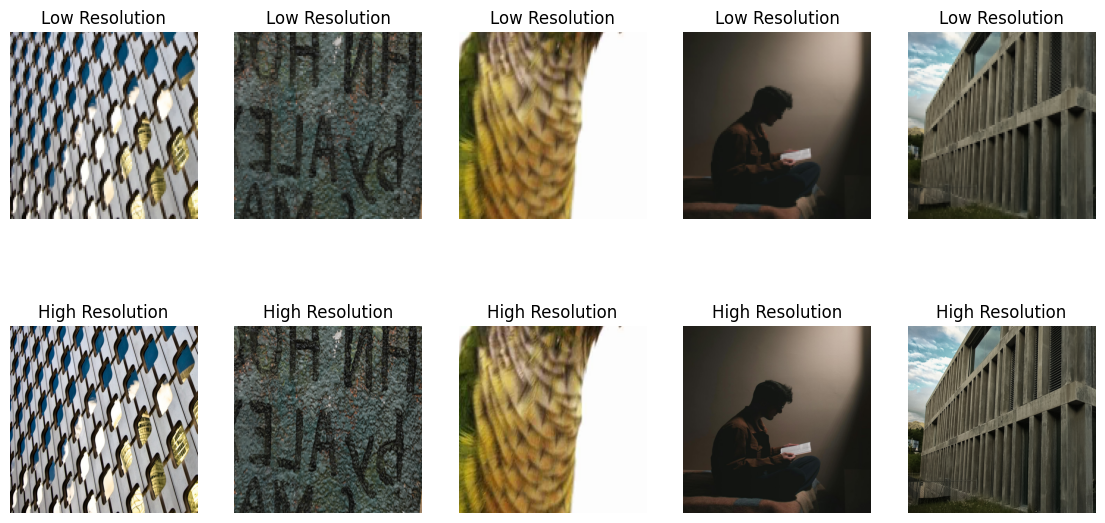

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lastimageprocessing (lastimageprocessing-webber-cameroon) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Model's Total Num Model Parameters: 17698383
The model size is 67.53 MB
Loaded checkpoint from /content/drive/MyDrive/Checkpoints/Eflic/checkpoint_global.pt
Resuming from step 176000 (epoch 13496)
Saved final checkpoint to /content/drive/MyDrive/Checkpoints/Eflic/checkpoint_final_tune.pt


In [ ]:
set_seed(42)  # Set a fixed seed for reproducibility

# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_dir = './Checkpoints'
results_dir = './Results'
samples_dir = './Samples'
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

train_dir = ''
val_dir   = ''

train_loader, val_loader = create_dataloaders(train_dir, val_dir, batch_size=42, patch_size=512, num_workers=4)

plot_dataset(train_loader)

# Create model and diffusion
model         = Generator()
discriminator = Discriminator()
# Create trainer
trainer = Trainer(
    model=model,
    discriminator=discriminator,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    device=device,
    resume=True,
    log_dir=checkpoint_dir,
    learning_rate=1e-4,
    pixel_weight=20.0,
    gp_weight=10.0,
    perceptual_weight=1.0,
    adversarial_weight=0.01,
    max_epochs=2500,
    project_name='ELRIC',
    name='elric'
)
resume_from = f"{checkpoint_dir}/checkpoint_global.pt"
# Start training
trainer.train(resume_from=resume_from)

# Inference

In [ ]:
def load_images(filename):
    hr_img = Image.open(filename).convert('RGB')
    hr_size = hr_img.size  # (width, height)
    lr_size = (hr_size[0] // 4, hr_size[1] // 4)
    lr_img = hr_img.resize(lr_size, Image.BICUBIC)
    transform = transforms.Compose([
      transforms.ToTensor(),
    ])
    lr_img = transform(lr_img)
    hr_img = transform(hr_img)
    lr_img = lr_img.unsqueeze(0)
    hr_img = hr_img.unsqueeze(0)
    return lr_img, hr_img

def load_image(filename):
    transform = transforms.Compose([
      transforms.ToTensor(),
    ])
    hr_img = Image.open(filename).convert('RGB')
    hr_img = transform(hr_img)
    hr_img = hr_img.unsqueeze(0)
    return hr_img

def plot_batch(batch):
    fig, axes = plt.subplots(2, 8, figsize=(20, 13))

    for i, (low_res, high_res) in enumerate(batch):
        if i >= 8:
            break
        axes[0, i].imshow(low_res.permute(1, 2, 0))
        axes[0, i].axis('off')

        axes[1, i].imshow(high_res.permute(1, 2, 0))
        axes[1, i].axis('off')

def plot_batch_comparison(high_res_batch, low_res_batch, num_images=8, save_path=None):
    # Ensure we don't try to display more images than we have
    #num_images = min(num_images, high_res_batch.size(0))

    # Create figure with tight layout
    fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))

    # Remove spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)

    # Normalize images if they're not already in [0,1] range
    if high_res_batch.max() > 1:
        high_res_batch = high_res_batch / 255.
    if low_res_batch.max() > 1:
        low_res_batch = low_res_batch / 255.

    for i in range(num_images):
        # Get high res and low res images
        high_res = high_res_batch[i]
        low_res = low_res_batch[i]

        # Convert from torch tensor [C,H,W] to numpy array [H,W,C]
        high_res = high_res.cpu().permute(1, 2, 0).numpy()
        low_res = low_res.cpu().permute(1, 2, 0).numpy()

        # Plot high resolution image
        axes[0, i].imshow(high_res)
        axes[0, i].axis('off')

        # Plot low resolution image
        axes[1, i].imshow(low_res)
        axes[1, i].axis('off')

    # Adjust layout to eliminate any remaining space
    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

# Inference function
def inference_dataset(model, test_loader, name, niqe_criterion, device):
    model.eval()
    model.to(device)
    test_psnr = 0.0
    test_ssim = 0.0
    test_niqe = 0.0

    with torch.no_grad():
        for batch_idx, (lr_imgs, hr_imgs) in enumerate(test_loader):
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(hr_imgs)

            plot_batch_comparison(lr_imgs, sr_imgs, num_images=8, save_path=f'{results_dir}/{name}_crop_test_batch_{batch_idx}.png')
            psnr, ssim_val = calculate_metrics(sr_imgs, lr_imgs)
            niqe = niqe_criterion(lr_imgs.cpu()).mean().cpu().item()
            test_psnr += psnr
            test_ssim += ssim_val
            test_niqe += niqe
            pass

    avg_test_psnr = test_psnr / len(test_loader)
    avg_test_ssim = test_ssim / len(test_loader)
    avg_test_niqe = test_niqe / len(test_loader)

    print(f'Test Results - PSNR: {avg_test_psnr:.4f}, SSIM: {avg_test_ssim:.4f}, , NIQE: {avg_test_niqe:.4f}')
    return avg_test_psnr, avg_test_ssim, avg_test_niqe

# Inference function
def inference(model, data_path, name, niqe_criterion, device):
    model.to(device)
    model.eval()
    test_psnr = 0.0
    test_ssim = 0.0
    test_niqe = 0.0
    total     = 0.0

    list_of_files = os.listdir(os.path.join(data_path))

    total = len(list_of_files)

    with torch.no_grad():
        for batch_idx, filename in enumerate(list_of_files):
            if filename == '.ipynb_checkpoints':
              continue
            file_path = data_path + '/' + filename

            lr_imgs, hr_imgs = load_images(file_path)

            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(hr_imgs)

            show(lr_imgs, sr_imgs)

            psnr, ssim_val = calculate_metrics(sr_imgs, lr_imgs)
            niqe = niqe_criterion(sr_imgs.cpu()).mean().cpu().item()
            test_psnr += psnr
            test_ssim += ssim_val
            test_niqe += niqe

            # Save some example results
            if batch_idx % 10 == 0:
                torchvision.utils.save_image(
                    torch.cat([lr_imgs, sr_imgs], dim=0),
                    f'{results_dir}/{name}_sample_batch_{batch_idx}.png',
                    normalize=True
                )

    avg_test_psnr = test_psnr / total
    avg_test_ssim = test_ssim / total
    avg_test_niqe = test_niqe / total

    print(f'Test Results - PSNR: {avg_test_psnr:.4f}, SSIM: {avg_test_ssim:.4f}, , NIQE: {avg_test_niqe:.4f}')
    return avg_test_psnr, avg_test_ssim, avg_test_niqe


# Inference function
def inference2(model, hr_path, lr_path, name, niqe_criterion, device):
    model.to(device)
    model.eval()
    test_psnr = 0.0
    test_ssim = 0.0
    test_niqe = 0.0
    total     = 0.0

    list_of_hr_files = sorted(os.listdir(os.path.join(hr_path)))
    list_of_lr_files = sorted(os.listdir(os.path.join(lr_path)))

    total = len(list_of_hr_files)

    with torch.no_grad():
        for batch_idx, (lrname, hrname) in enumerate(zip(list_of_lr_files, list_of_hr_files)):
            if hrname == '.ipynb_checkpoints':
              continue
            hr_file_path = hr_path + '/' + hrname
            lr_file_path = lr_path + '/' + lrname

            hr_imgs = load_image(hr_file_path)
            lr_imgs = load_image(lr_file_path)

            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(hr_imgs)

            show(lr_imgs, sr_imgs)

            psnr, ssim_val = calculate_metrics(sr_imgs, lr_imgs)
            niqe = niqe_criterion(sr_imgs.cpu()).mean().cpu().item()
            test_psnr += psnr
            test_ssim += ssim_val
            test_niqe += niqe

            # Save some example results
            if batch_idx % 10 == 0:
                torchvision.utils.save_image(
                    torch.cat([lr_imgs, sr_imgs], dim=0),
                    f'{results_dir}/{name}_sample_batch_{batch_idx}.png',
                    normalize=True
                )

    avg_test_psnr = test_psnr / total
    avg_test_ssim = test_ssim / total
    avg_test_niqe = test_niqe / total

    print(f'Test Results - PSNR: {avg_test_psnr:.4f}, SSIM: {avg_test_ssim:.4f}, , NIQE: {avg_test_niqe:.4f}')
    return avg_test_psnr, avg_test_ssim, avg_test_niqe

In [ ]:
import pyiqa
iqa_metric = pyiqa.create_metric('niqe')


In [ ]:
def load_image(image_path):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Load the image
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)
    return image


def infer(image_path, sharp_file, file_name, trainer, out_name = '/kaggle/working/gen_results', device='cpu', timesteps=1000):

    trainer.device = device
    trainer.model  = trainer.model.to(device)
    trainer.model.eval()

    # Load the image
    hr_image = load_image(image_path).to(device)
    print("Processing image: ", image_path)
    print(hr_image.shape)
    sr_imgs = trainer.model(hr_image)
    print(sr_imgs.shape)
    # Save the image
    save_image_tensor(hr_image, out_name+f'normal_{file_name}')
    save_image_tensor(sr_imgs, out_name+f'low_{file_name}')
    lr_image = load_image(sharp_file).to(device)
    print(lr_image.shape)
    psnr, ssim = calculate_metrics(lr_image, sr_imgs)
    print(f"PSNR: {psnr}, SSIM: {ssim}")
    # Display the original, compressed, and decompressed images
    plt.subplot(1, 3, 1)
    plt.imshow(get_pil_image(hr_image.detach().cpu().squeeze(0)))
    plt.title('High Resolution Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(get_pil_image(lr_image.detach().cpu().squeeze(0)))
    plt.title('Original Low Image')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(get_pil_image(sr_imgs.detach().cpu().squeeze(0)))
    plt.title('Model Low Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()
    del hr_image, lr_image, sr_imgs
    torch.cuda.empty_cache()

def extract_file_number(file_name):
    # Extract the numerical part of the file name
    # Example: '0001x4.png' -> 1
    return int(file_name.split('/')[-1].split('x')[0])

def sort_file_names(file_paths):
    # Convert file paths to a PyTorch tensor for sorting
    file_numbers = torch.tensor([extract_file_number(fp) for fp in file_paths])
    
    # Get the sorted indices
    sorted_indices = torch.argsort(file_numbers)
    
    # Sort the file paths based on the sorted indices
    sorted_file_paths = [file_paths[i] for i in sorted_indices]
    return sorted_file_paths



In [ ]:
with torch.no_grad():
    data_path = '/kaggle/input/div2k-dataset-for-super-resolution/Dataset/DIV2K_train_HR'
    sharp_dir = '/kaggle/input/div2k-dataset-for-super-resolution/Dataset/DIV2K_train_LR_bicubic_X4/X4'
    results_dir = 'samples/'
    os.makedirs(results_dir, exist_ok=True)
    list_of_files      = sort_file_names(os.listdir(os.path.join(data_path)))
    list_of_shap_files = sorted(os.listdir(os.path.join(sharp_dir)))
    i = 0
    for j, file in enumerate(list_of_files):
        if file == '.ipynb_checkpoints':
            continue
        file_path  = data_path + '/' + file
        sharp_path = sharp_dir + '/' + list_of_shap_files[i]
        infer(file_path, sharp_path, file, trainer, out_name=results_dir, device='cpu')
        i = i+1
        if i==150:
            break

In [ ]:
sr_image = load_image("/content/0828.png")
hr_image = generator(sr_image)
plt.imshow(get_pil_image(hr_image.detach().cpu().squeeze(0)))
plt.axis('off')
plt.tight_layout()
plt.show()